In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import requests
import random
import math

In [ ]:
def get_data(url):
  raw_file_url = url

  response = requests.get(raw_file_url)

  if response.status_code != 200:
    return ""

  return response.text

In [ ]:
tmp = get_data('https://raw.githubusercontent.com/AbhinayWorkSpace/802_project/main/supervised.csv')
lines = tmp.strip().split('\n')

headers = lines[0].split(',')
headers = [x.rstrip() for x in headers]

data_rows = [line.split(',') for line in lines[1:]]

cleaned = []
for line in data_rows:
  tmp = []
  for x in line:
    x = x.rstrip()
    tmp.append(float(x))
  cleaned.append(tmp)

random.seed(902)
random.shuffle(cleaned)

df = pd.DataFrame(cleaned, columns=headers)
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1454.0,1.0,1.6,0.0,6.0,1.0,21.0,0.2,160.0,4.0,...,186.0,1100.0,719.0,14.0,10.0,10.0,1.0,1.0,1.0,0.0
1,1866.0,1.0,2.5,1.0,3.0,1.0,47.0,0.8,89.0,5.0,...,358.0,1782.0,1444.0,7.0,4.0,20.0,1.0,0.0,0.0,1.0
2,1770.0,0.0,2.3,1.0,0.0,0.0,7.0,0.8,128.0,7.0,...,886.0,1552.0,1480.0,6.0,1.0,17.0,1.0,0.0,0.0,1.0
3,1896.0,0.0,0.5,1.0,8.0,1.0,7.0,0.4,141.0,2.0,...,447.0,794.0,3684.0,9.0,7.0,18.0,1.0,0.0,0.0,3.0
4,1183.0,1.0,0.5,1.0,3.0,1.0,48.0,0.1,120.0,8.0,...,268.0,1010.0,1152.0,8.0,3.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1261.0,1.0,0.5,1.0,0.0,1.0,11.0,0.2,90.0,4.0,...,858.0,1591.0,348.0,14.0,9.0,14.0,1.0,0.0,1.0,0.0
1996,1387.0,0.0,0.5,0.0,0.0,1.0,61.0,0.5,98.0,3.0,...,785.0,1151.0,629.0,5.0,3.0,11.0,1.0,1.0,0.0,0.0
1997,871.0,0.0,0.6,0.0,2.0,0.0,52.0,0.1,178.0,3.0,...,194.0,1437.0,437.0,14.0,7.0,17.0,1.0,0.0,0.0,0.0
1998,1507.0,1.0,0.9,1.0,0.0,1.0,42.0,0.4,123.0,5.0,...,682.0,888.0,1486.0,15.0,3.0,19.0,1.0,0.0,0.0,1.0


In [ ]:
def mle_mean(n, train_set):
  l = len(train_set.axes[1]) - 1
  total = np.zeros((l, 1))

  for _, val in train_set.iterrows():
    tmp = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        tmp[idx] = val.values[idx]
    total += tmp

  return (1/n)*total


In [ ]:
def mle_sig(n, train_set, mu):
  l = len(train_set.axes[1]) - 1
  total = np.zeros((l, l))

  for _, val in train_set.iterrows():
    tmp = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        tmp[idx] = val.values[idx]
    total += (tmp - mu) @ (tmp - mu).T

  return (1/n)*total

In [ ]:

def guassian(d, x, mu, sig):
  e = -0.5*(x - mu).T @ np.linalg.inv(sig) @ (x - mu)
  dnm = (2*math.pi)**(d/2) * (np.linalg.det(sig))**0.5

  return np.exp(e)/dnm

def bayes_rule(pattern, means, sigs):
  class0 = guassian(d=len(pattern) - 1, x=pattern, mu=means[0], sig=sigs[0])
  class1 = guassian(d=len(pattern) - 1, x=pattern, mu=means[1], sig=sigs[1])
  class2 = guassian(d=len(pattern) - 1, x=pattern, mu=means[2], sig=sigs[2])
  class3 = guassian(d=len(pattern) - 1, x=pattern, mu=means[3], sig=sigs[3])

  lt = [class0, class1, class2, class3]
  dt = {0: 0, 1: 1, 2: 2, 3: 3}

  mx_idx = -1
  mx_val = -float("inf")
  for i in range(len(lt)):
    if lt[i] > mx_val:
      mx_idx = i
      mx_val = lt[i]

  return dt[mx_idx]

In [ ]:
def results(df):

  actual = []
  predict = []

  try:
    classes = df.groupby("price_range")
  except:
    return [], 0

  class0 = classes.get_group(0)
  class1 = classes.get_group(1)
  class2 = classes.get_group(2)
  class3 = classes.get_group(3)

  bound = int(len(class0) * 0.8)
  train0 = class0[:bound]
  test0 = class0[bound:]

  bound = int(len(class1) * 0.8)
  train1 = class1[:bound]
  test1 = class1[bound:]

  bound = int(len(class2) * 0.8)
  train2 = class2[:bound]
  test2 = class2[bound:]

  bound = int(len(class3) * 0.8)
  train3 = class3[:bound]
  test3 = class3[bound:]

  for x in test0["price_range"].values:
    actual.append(x)
  for x in test1["price_range"].values:
    actual.append(x)
  for x in test2["price_range"].values:
    actual.append(x)
  for x in test3["price_range"].values:
    actual.append(x)

  mean0 = mle_mean(len(train0), train0)
  sig0 = mle_sig(len(train0), train0, mean0)

  mean1 = mle_mean(len(train1), train1)
  sig1 = mle_sig(len(train1), train1, mean1)

  mean2 = mle_mean(len(train2), train2)
  sig2 = mle_sig(len(train2), train2, mean2)

  mean3 = mle_mean(len(train3), train3)
  sig3 = mle_sig(len(train3), train3, mean3)

  means = [mean0, mean1, mean2, mean3]
  sigs = [sig0, sig1, sig2, sig3]

  for _, val in test0.iterrows():
    l = len(val) - 1
    tmp = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        tmp[idx] = val.values[idx]
    predict.append(bayes_rule(tmp, means, sigs))

  for _, val in test1.iterrows():
    l = len(val) - 1
    tmp = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        tmp[idx] = val.values[idx]
    predict.append(bayes_rule(tmp, means, sigs))

  for _, val in test2.iterrows():
    l = len(val) - 1
    tmp = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        tmp[idx] = val.values[idx]
    predict.append(bayes_rule(tmp, means, sigs))

  for _, val in test3.iterrows():
    l = len(val) - 1
    tmp = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        tmp[idx] = val.values[idx]
    predict.append(bayes_rule(tmp, means, sigs))

  cf = confusion_matrix(actual, predict)
  return cf, (len(test1) - cf[0][0] + len(test2) - cf[1][1]+ len(test3) - cf[2][2])/(len(test1) + len(test2) + len(test3))

In [ ]:
results(df)

(array([[95,  5,  0,  0],
        [ 6, 90,  4,  0],
        [ 0,  4, 87,  9],
        [ 0,  0,  5, 95]]),
 0.09333333333333334)

In [ ]:
results(df[['battery_power', 'clock_speed', 'dual_sim', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram', 'wifi', 'price_range']])

(array([[99,  1,  0,  0],
        [ 7, 92,  1,  0],
        [ 0,  5, 91,  4],
        [ 0,  0,  3, 97]]),
 0.06)

In [ ]:
def sfs(target, df):
  classes = df.columns.tolist()[-1]

  y = set(df.columns.tolist()[:-1])
  x_k = set()
  k = 0

  while k < target:

    x_plus = None
    mx_vl = -float('inf')
    for x in (y - x_k):
      tmp = list(x_k.copy())
      tmp.append(x)
      tmp.append(classes)

      j = 1-results(df[tmp])[1]
      if j > mx_vl:
        x_plus  = x
        mx_vl = j

    x_k.add(x_plus)

    k += 1
  return x_k, mx_vl

#sfs(5, df)

In [ ]:
def sffs(target, df):
  classes = df.columns.tolist()[-1]

  y = set(df.columns.tolist()[:-1])
  x_k = set()
  k = 0

  while k < target:

    x_plus = None
    mx_vl = -float('inf')
    for x in (y - x_k):
      tmp = list(x_k.copy())
      tmp.append(x)
      tmp.append(classes)

      j = 1-results(df[tmp])[1]
      if j > mx_vl:
        x_plus  = x
        mx_vl = j

    x_k.add(x_plus)

    k += 1

    while True:
      x_minus = None
      mn_val = -float('inf')
      for x in x_k:
        tmp = x_k.copy().discard(x)

        if tmp is None:
          tmp = []
        else:
          tmp = list(tmp)
          tmp.append(classes)

        j = 1-results(df[tmp])[1]
        if j > mx_vl:
          x_minus  = x
          mn_vl = j

      tmp1 = x_k.copy().discard(mn_vl)
      if tmp1 is None:
        tmp1 = []
      else:
        tmp1 = list(tmp1)
        tmp1.append(classes)

      tmp2 = x_k.copy().discard(mx_vl)
      if tmp2 is None:
        tmp2 = []
      else:
        tmp2 = list(tmp2)
        tmp2.append(classes)

      if (1-results(df[tmp1])[1]) > (1-results(df[tmp2])[1]):
        x_k.discard(mn_vl)
        k -= 1
      else:
        break

  return x_k, mx_vl

#sffs(5, df)

In [ ]:
results(None)[1]

0

In [ ]:
def pca(df):
  l = len(df.axes[1]) - 1

  mean = np.zeros((l, 1))
  for _, val in df.iterrows():
    for idx in range(len(val.values)):
      if idx != l:
        mean[idx] += val.values[idx]
  mean /= len(df)

  scatter = np.zeros((l, l))
  for _, val in df.iterrows():
    x_k = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x_k[idx] = val.values[idx]

    scatter += (x_k - mean) @ (x_k - mean).T

  eigenvalues, eigenvectors = np.linalg.eig(scatter)
  sorted_indices = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]

  pca1 = sorted_eigenvectors[:, 0]
  pca1 = np.reshape(pca1, (l, 1))

  pca2 = sorted_eigenvectors[:, 1]
  pca2 = np.reshape(pca2, (l, 1))

  tmp = []
  for _, val in df.iterrows():
    x_k = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x_k[idx] = val.values[idx]

    val1 = pca1.T @ x_k
    val2 = pca2.T @ x_k

    tmp.append((val1[0][0], val2[0][0]))

  new_pca = pd.DataFrame(tmp, columns=["pca1", "pca2"])
  new_pca["price_range"] = df["price_range"]

  return new_pca

results(pca(df))

(array([[89, 11,  0,  0],
        [13, 79,  8,  0],
        [ 0, 25, 60, 15],
        [ 0,  0, 13, 87]]),
 0.24)

In [ ]:
def mda(df):
  l = len(df.axes[1]) - 1

  tmp = df.groupby("price_range")

  m_1 = np.zeros((l, 1))
  for _, val in tmp.get_group(0).iterrows():
    for idx in range(len(val.values)):
      if idx != l:
        m_1[idx] += val.values[idx]
  m_1 /= len(tmp.get_group(0))

  m_2 = np.zeros((l, 1))
  for _, val in tmp.get_group(1).iterrows():
    for idx in range(len(val.values)):
      if idx != l:
        m_2[idx] += val.values[idx]
  m_2 /= len(tmp.get_group(1))

  m_3 = np.zeros((l, 1))
  for _, val in tmp.get_group(2).iterrows():
    for idx in range(len(val.values)):
      if idx != l:
        m_3[idx] += val.values[idx]
  m_3 /= len(tmp.get_group(2))

  m_4 = np.zeros((l, 1))
  for _, val in tmp.get_group(3).iterrows():
    for idx in range(len(val.values)):
      if idx != l:
        m_4[idx] += val.values[idx]
  m_4 /= len(tmp.get_group(3))

  m = np.zeros((l, 1))
  m = len(tmp.get_group(0)) * m_1 + len(tmp.get_group(1)) * m_2 + len(tmp.get_group(2)) * m_3 + len(tmp.get_group(3)) * m_4
  m /= len(df)

  s_1 = np.zeros((l, l))
  for _, val in tmp.get_group(0).iterrows():
    x = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x[idx] = val.values[idx]

    s_1 += (x - m_1) @ (x - m_1).T

  s_2 = np.zeros((l, l))
  for _, val in tmp.get_group(1).iterrows():
    x = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x[idx] = val.values[idx]

    s_2 += (x - m_2) @ (x - m_2).T

  s_3 = np.zeros((l, l))
  for _, val in tmp.get_group(2).iterrows():
    x = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x[idx] = val.values[idx]

    s_3 += (x - m_3) @ (x - m_3).T

  s_4 = np.zeros((l, l))
  for _, val in tmp.get_group(3).iterrows():
    x = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x[idx] = val.values[idx]

    s_4 += (x - m_4) @ (x - m_4).T

  s_w = s_1 + s_2 + s_3 + s_4

  s_1 = np.zeros((l, l))
  s_1 = len(tmp.get_group(0)) * (m_1 - m) @ (m_1 - m).T

  s_2 = np.zeros((l, l))
  s_2 = len(tmp.get_group(1)) * (m_2 - m) @ (m_2 - m).T

  s_3 = np.zeros((l, l))
  s_3 = len(tmp.get_group(2)) * (m_3 - m) @ (m_3 - m).T

  s_4 = np.zeros((l, l))
  s_4 = len(tmp.get_group(3)) * (m_4 - m) @ (m_4 - m).T

  s_b = s_1 + s_2 + s_3 + s_4

  s = np.linalg.inv(s_w) @ s_b

  eigenvalues, eigenvectors = np.linalg.eig(s)
  sorted_indices = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]

  mda1 = sorted_eigenvectors[:, 0]
  mda1 = np.reshape(mda1, (l, 1))

  mda2 = sorted_eigenvectors[:, 1]
  mda2 = np.reshape(mda2, (l, 1))

  tmp = []
  for _, val in df.iterrows():
    x_k = np.zeros((l, 1))
    for idx in range(len(val.values)):
      if idx != l:
        x_k[idx] = val.values[idx]

    val1 = mda1.T @ x_k
    val2 = mda2.T @ x_k

    tmp.append((val1[0][0], val2[0][0]))

  new_mda = pd.DataFrame(tmp, columns=["mda1", "mda2"])
  new_mda["price_range"] = df["price_range"]

  return new_mda

results(mda(df))

<ipython-input-49-2f1b254c939d>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp[idx] = val.values[idx]
<ipython-input-52-489228b1c290>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp[idx] = val.values[idx]
<ipython-input-52-489228b1c290>:69: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp[idx] = val.values[idx]
<ipython-input-52-489228b1c290>:77: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp[idx] = val.values[idx]
<ipython-input-52-489228b1c290>:85: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp[idx] = val.values[idx]


(array([[100,   0,   0,   0],
        [  6,  92,   2,   0],
        [  0,   8,  87,   5],
        [  0,   0,   4,  96]]),
 0.07)

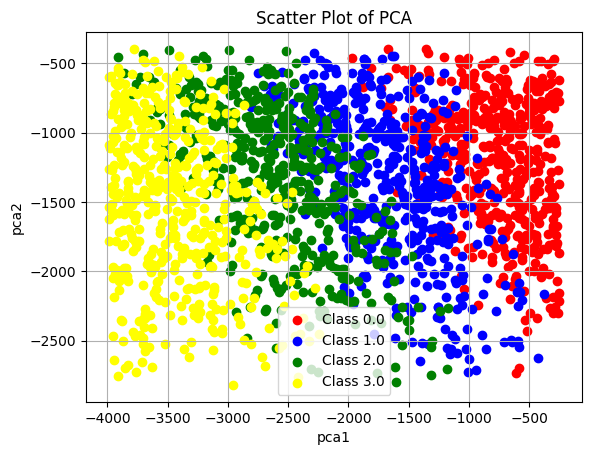

In [ ]:
group_colors = {0: 'red', 1: 'blue', 2: 'green', 3:'yellow'}
group_pca = pca(df).groupby("price_range")

for group, group_data in group_pca:
    plt.scatter(group_data['pca1'], group_data['pca2'], label=f'Class {group}', color=group_colors[group])

plt.title('Scatter Plot of PCA')
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.grid(True)
plt.legend()

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


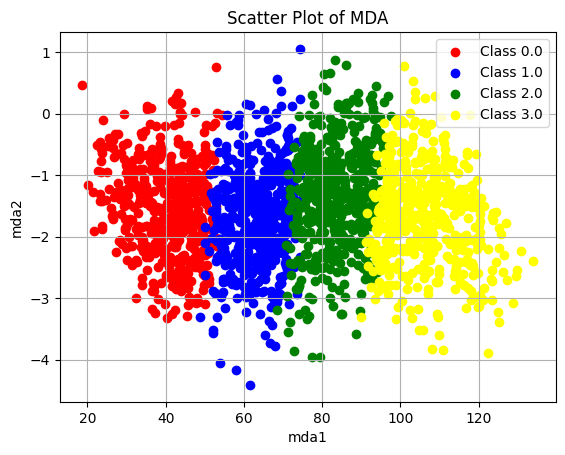

In [ ]:
group_colors = {0: 'red', 1: 'blue', 2: 'green', 3:'yellow'}
group_new_mda = mda(df).groupby("price_range")

for group, group_data in group_new_mda:
    plt.scatter(group_data['mda1'], group_data['mda2'], label=f'Class {group}', color=group_colors[group])

plt.title('Scatter Plot of MDA')
plt.xlabel('mda1')
plt.ylabel('mda2')
plt.grid(True)
plt.legend()

plt.show()

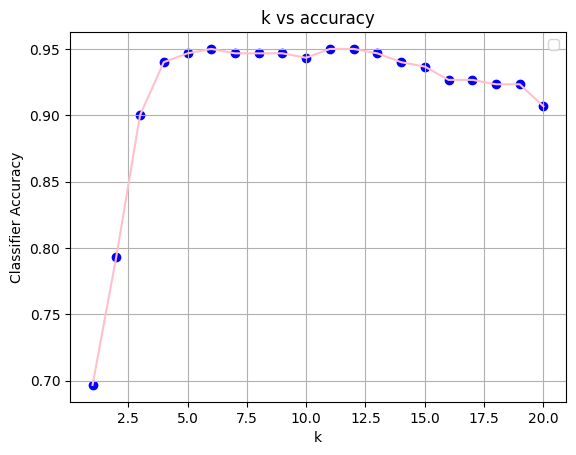

[({'ram'}, 0.6966666666666667),
 ({'battery_power', 'ram'}, 0.7933333333333333),
 ({'battery_power', 'px_height', 'ram'}, 0.9),
 ({'battery_power',
   'blue',
   'clock_speed',
   'dual_sim',
   'fc',
   'four_g',
   'int_memory',
   'm_dep',
   'mobile_wt',
   'n_cores',
   'pc',
   'px_height',
   'px_width',
   'ram',
   'sc_h',
   'sc_w',
   'talk_time',
   'three_g',
   'touch_screen',
   'wifi'},
  0.9066666666666666),
 ({'battery_power',
   'blue',
   'clock_speed',
   'dual_sim',
   'fc',
   'four_g',
   'int_memory',
   'n_cores',
   'pc',
   'px_height',
   'px_width',
   'ram',
   'sc_h',
   'sc_w',
   'talk_time',
   'three_g',
   'touch_screen',
   'wifi'},
  0.9233333333333333),
 ({'battery_power',
   'blue',
   'clock_speed',
   'dual_sim',
   'fc',
   'four_g',
   'int_memory',
   'mobile_wt',
   'n_cores',
   'pc',
   'px_height',
   'px_width',
   'ram',
   'sc_h',
   'sc_w',
   'talk_time',
   'three_g',
   'touch_screen',
   'wifi'},
  0.9233333333333333),
 ({'batte

In [ ]:
x = np.arange(1, 21, 1)
y = []

sfs_answer = []

for vl in x:
  f_set, acc = sfs(vl, df)

  sfs_answer.append((f_set, acc))
  y.append(acc)

plt.scatter(x, y, c ="blue")
plt.plot(x, y, c ="pink")

plt.title('k vs accuracy')
plt.xlabel('k')
plt.ylabel('Classifier Accuracy')
plt.grid(True)
plt.legend()

plt.show()

sfs_answer.sort(key=lambda l: l[1])
sfs_answer

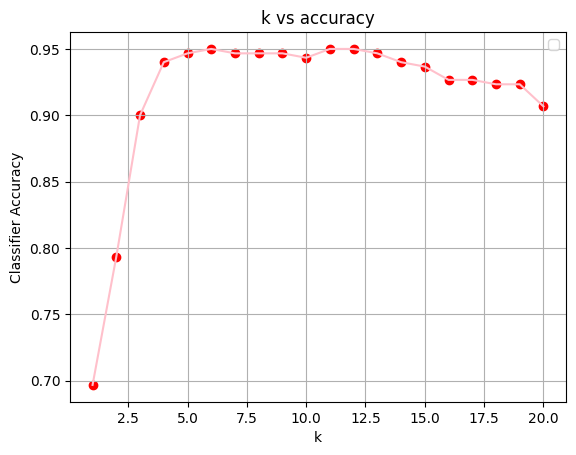

[({'ram'}, 0.6966666666666667),
 ({'battery_power', 'ram'}, 0.7933333333333333),
 ({'battery_power', 'px_height', 'ram'}, 0.9),
 ({'battery_power',
   'blue',
   'clock_speed',
   'dual_sim',
   'fc',
   'four_g',
   'int_memory',
   'm_dep',
   'mobile_wt',
   'n_cores',
   'pc',
   'px_height',
   'px_width',
   'ram',
   'sc_h',
   'sc_w',
   'talk_time',
   'three_g',
   'touch_screen',
   'wifi'},
  0.9066666666666666),
 ({'battery_power',
   'blue',
   'clock_speed',
   'dual_sim',
   'fc',
   'four_g',
   'int_memory',
   'n_cores',
   'pc',
   'px_height',
   'px_width',
   'ram',
   'sc_h',
   'sc_w',
   'talk_time',
   'three_g',
   'touch_screen',
   'wifi'},
  0.9233333333333333),
 ({'battery_power',
   'blue',
   'clock_speed',
   'dual_sim',
   'fc',
   'four_g',
   'int_memory',
   'mobile_wt',
   'n_cores',
   'pc',
   'px_height',
   'px_width',
   'ram',
   'sc_h',
   'sc_w',
   'talk_time',
   'three_g',
   'touch_screen',
   'wifi'},
  0.9233333333333333),
 ({'batte

In [ ]:
x = np.arange(1, 21, 1)
y = []

sffs_answer = []

for vl in x:
  f_set, acc = sffs(vl, df)

  sffs_answer.append((f_set, acc))
  y.append(acc)

plt.scatter(x, y, c ="red")
plt.plot(x, y, c ="pink")

plt.title('k vs accuracy')
plt.xlabel('k')
plt.ylabel('Classifier Accuracy')
plt.grid(True)
plt.legend()

plt.show()

sffs_answer.sort(key=lambda l: l[1])
sffs_answer